In [1]:
!rm -rf CudaProgramming
!git clone https://github.com/MarouaneMaac/CudaProgramming

Cloning into 'CudaProgramming'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 21 (delta 3), reused 16 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 45.22 KiB | 3.01 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
!pip install ninja
!rm -rf load_inline_cuda
!mkdir load_inline_cuda

# Base Matrix Multiplication

In [3]:
import torch
from torch.utils.cpp_extension import load_inline

In [4]:
torch.cuda.is_available()

True

In [5]:
cuda_source_path = './CudaProgramming/chapter_3/matmul_kernel.cu'

with open(cuda_source_path, 'r') as file:
    cuda_source = file.read()

In [6]:
import traceback
cpp_source = "torch::Tensor matrix_multiplication(torch::Tensor matrix_1,torch::Tensor matrix_2);"


matmul_extension = load_inline(
      name='matmul_extension',
      cpp_sources=cpp_source,
      cuda_sources=cuda_source,
      functions=['matrix_multiplication'],
      with_cuda=True,
      verbose=True,
      extra_cuda_cflags=["-O2"],
      build_directory='./load_inline_cuda',)


# Check correctness

In [7]:
mat1 = torch.rand(32, 32)
mat2 = torch.rand(32, 32)

mat1_cuda = mat1.cuda()
mat2_cuda = mat2.cuda()

custom_kernel_out = matmul_extension.matrix_multiplication(mat1_cuda, mat2_cuda)
torch_out = torch.matmul(mat1, mat2)

torch.testing.assert_allclose(custom_kernel_out.cpu(), torch_out)

/tmp/ipython-input-3315501999.py:10: FutureWarning: `torch.testing.assert_allclose()` is deprecated since 1.12 and will be removed in a future release. Please use `torch.testing.assert_close()` instead. You can find detailed upgrade instructions in https://github.com/pytorch/pytorch/issues/61844.
  torch.testing.assert_allclose(custom_kernel_out.cpu(), torch_out)


In [8]:
mat1 = torch.rand(32, 16)
mat2 = torch.rand(16, 32)

mat1_cuda = mat1.cuda()
mat2_cuda = mat2.cuda()

custom_kernel_out = matmul_extension.matrix_multiplication(mat1_cuda, mat2_cuda)
torch_out = torch.matmul(mat1, mat2)

torch.testing.assert_allclose(custom_kernel_out.cpu(), torch_out)

/tmp/ipython-input-769665675.py:10: FutureWarning: `torch.testing.assert_allclose()` is deprecated since 1.12 and will be removed in a future release. Please use `torch.testing.assert_close()` instead. You can find detailed upgrade instructions in https://github.com/pytorch/pytorch/issues/61844.
  torch.testing.assert_allclose(custom_kernel_out.cpu(), torch_out)


# Speed comparison

In [9]:
from time import time

In [10]:
def time_method(method, size, device):
  a = torch.rand(size, size, device=device, dtype=torch.float32)
  b = torch.rand(size, size, device=device, dtype=torch.float32)
  s = time()
  method(a, b)
  e = time()
  return e-s

In [15]:
x = list(range(6, 15))
gpu_times = [time_method(matmul_extension.matrix_multiplication, int(2**i), device='cuda') for i in x]
torch_gpu_times = [time_method(lambda x, y: torch.matmul(x, y), int(2**i), device='cuda') for i in x]
cpu_times = [time_method(lambda x, y: torch.matmul(x, y), int(2**i), device='cpu') for i in x]

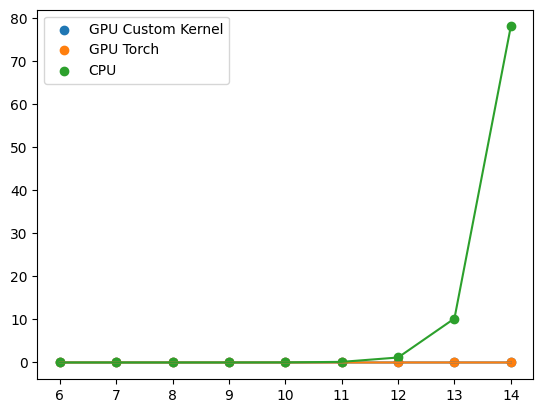

In [16]:
import matplotlib.pyplot as plt
plt.scatter(x, gpu_times, label='GPU Custom Kernel')
plt.scatter(x, torch_gpu_times, label='GPU Torch')
plt.scatter(x, cpu_times, label='CPU')
plt.plot(x, gpu_times)
plt.plot(x, torch_gpu_times)
plt.plot(x, cpu_times)
plt.legend()
plt.show()

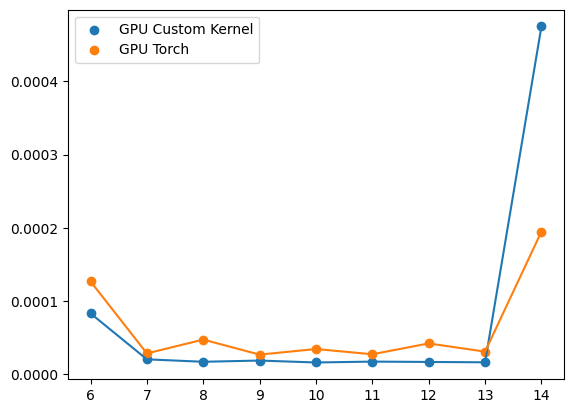

In [17]:
import matplotlib.pyplot as plt
plt.scatter(x, gpu_times, label='GPU Custom Kernel')
plt.scatter(x, torch_gpu_times, label='GPU Torch')
plt.plot(x, gpu_times)
plt.plot(x, torch_gpu_times)
plt.legend()
plt.show()

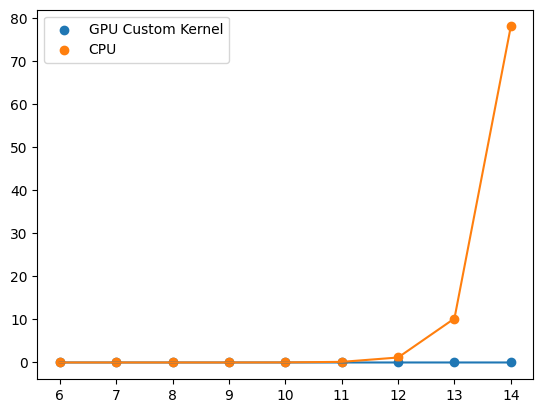

In [18]:
import matplotlib.pyplot as plt
plt.scatter(x, gpu_times, label='GPU Custom Kernel')
plt.scatter(x, cpu_times, label='CPU')
plt.plot(x, gpu_times)
plt.plot(x, cpu_times)
plt.legend()
plt.show()

In [19]:
cpu_times[-1] / gpu_times[-1]

164232.55650426922